<a href="https://colab.research.google.com/github/Belal-Darwish9/DeepLearning_project/blob/main/Recurrent%20Neural%20Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Recurrent Neural Networks.**

### **This notebook includes codes on recurrent neural networks for binary sentiment classification.**

# **Importing the libraries.**

In [1]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.8 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import random
import zipfile
import os
import keras_tuner as kt
from tensorflow.keras.utils import plot_model
import shutil
import seaborn as sns
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

# **Importing the dataset.**

In [3]:
data = pd.read_csv('/content/drive/MyDrive/MyCode_DeepLearning/movie.csv')

### **Split a Dataframe to Feature and label.**

In [4]:
X = data['text']
Y = data['label']

In [5]:
X.head()

,text
0,I grew up (b. 1965) watching and loving the Th...
1,"When I put this movie in my DVD player, and sa..."
2,Why do people who do not know what a particula...
3,Even though I have great interest in Biblical ...
4,Im a die hard Dads Army fan and nothing will e...


In [6]:
Y.head()

,label
0,0
1,0
2,0
3,0
4,1


### **Check how many examples you have.**

In [7]:
print(f'Number of examples: {len(X)}')

Number of examples: 40000


### **split data into train and test.**

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [9]:
len(x_train), len(x_test), len(y_train), len(y_test)

(28000, 12000, 28000, 12000)

# **Data preprocessing.**

### **Tokenize words at the level and convert words to numbers.**

In [10]:
max_words = 14000
max_len = 200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)
X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [11]:
print(f'Number of unique words: {len(tokenizer.word_index)}')
print(f'Max number of words in a sentence: {max_len}')
print(f'Average length of sentences: {round(sum([len(s) for s in X_train])/len(X_train))}')

Number of unique words: 95465
Max number of words in a sentence: 200
Average length of sentences: 200


In [12]:
print(f'example before tokenization:\n {x_train[0]}, label {y_train[0]} \n\n')
print(f'example after tokenization: \n{X_train[0]}, label {y_train[0]}')

example before tokenization:
 I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment., label 0 


example after tokenization: 
[    0     0     0     0     0     0     0     0     0

# **Build model callbacks.**

In [13]:
Filepath = 'content/best_model.keras'
Model_CheckPoint = tf.keras.callbacks.ModelCheckpoint(filepath=Filepath,
                                                      monitor='val_accuracy',
                                                      save_best_only=True,
                                                      mode = 'max')

Early_Stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  restore_best_weights=True,
                                                  mode = 'min')

Reduce_Learningrate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                           factor=0.2,
                                                           patience=2,
                                                           verbose=1,
                                                           min_lr=1e-7,
                                                           mode = 'min')

# **Build a simple RNN model.**

In [17]:
RNN_simple = tf.keras.Sequential()
RNN_simple.add(tf.keras.layers.Embedding(input_dim=14000, output_dim=128, input_length=200,
                                         name='Embedding_layer'))
RNN_simple.add(tf.keras.layers.SimpleRNN(128, return_sequences=True, name='SimpleRNN_layer_1'))
RNN_simple.add(tf.keras.layers.SimpleRNN(64, return_sequences=True, name='SimpleRNN_layer_2'))
RNN_simple.add(tf.keras.layers.SimpleRNN(64, return_sequences=True, name='SimpleRNN_layer_3'))
RNN_simple.add(tf.keras.layers.SimpleRNN(32, name='SimpleRNN_layer_4'))
RNN_simple.add(tf.keras.layers.Dense(64, activation='relu', name='Dense_layer_1'))
RNN_simple.add(tf.keras.layers.Dense(1, activation='sigmoid', name='Dense_output'))

### **Compiling a RNN model.**

In [18]:
RNN_simple.compile(loss='binary_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

### **RNN model training.**

**This cell may take a long time to run due to the use of SimpleRNN layers which suffer from *vanishing and exploding problem*.**

In [19]:
Epochs = 10
RNN_simple_history = RNN_simple.fit(X_train,
                                    y_train,
                                   batch_size=32,
                                   epochs=Epochs,
                                   validation_data= (X_test, y_test),
                                   validation_steps=int(0.3 * len(x_test)),
                                   callbacks=[Model_CheckPoint, Early_Stopping, Reduce_Learningrate])

Epoch 1/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 98s 104ms/step - accuracy: 0.5048 - loss: 0.7013 - val_accuracy: 0.4873 - val_loss: 0.6974 - learning_rate: 0.0010
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


875/875 ━━━━━━━━━━━━━━━━━━━━ 142s 107ms/step - accuracy: 0.5061 - loss: 0.6980 - val_accuracy: 0.5025 - val_loss: 0.6990 - learning_rate: 0.0010
Epoch 3/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 93s 106ms/step - accuracy: 0.4892 - loss: 0.6976 - val_accuracy: 0.5030 - val_loss: 0.6939 - learning_rate: 0.0010
Epoch 4/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 141s 105ms/step - accuracy: 0.5017 - loss: 0.6953 - val_accuracy: 0.5030 - val_loss: 0.6956 - learning_rate: 0.0010
Epoch 5/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4990 - loss: 0.6953
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
875/875 ━━━━━━━━━━━━━━━━━━━━ 142s 106ms/step - accuracy: 0.4990 - loss: 0.6953 - val_accuracy: 0.5015 - val_loss: 0.6949 - learning_rate: 0.0010
Epoch 6/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 133s 95ms/step - accuracy: 0.5036 - loss: 0.6938 - val_accuracy: 0.5002 - val_loss: 0.6933 - learning_rate: 2.0000e-04
Epoch 7/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 142s 95ms/step - accuracy: 0.5026 - 

### **RNN model summary.**

In [20]:
RNN_simple.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Embedding_layer (Embedding)          │ (32, 200, 128)              │       1,792,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ SimpleRNN_layer_1 (SimpleRNN)        │ (32, 200, 128)              │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ SimpleRNN_layer_2 (SimpleRNN)        │ (32, 200, 64)               │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ SimpleRNN_layer_3 (SimpleRNN)        │ (32, 200, 64)               │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ SimpleRNN_layer_4 (SimpleRNN)        │ (32, 32)                    │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_layer_1 (Dense)                │ (32, 64)                    │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_output (Dense)                 │ (32, 1)                     │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,552,357 (21.18 MB)

 Trainable params: 1,850,785 (7.06 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,701,572 (14.12 MB)

### **Plot model.**

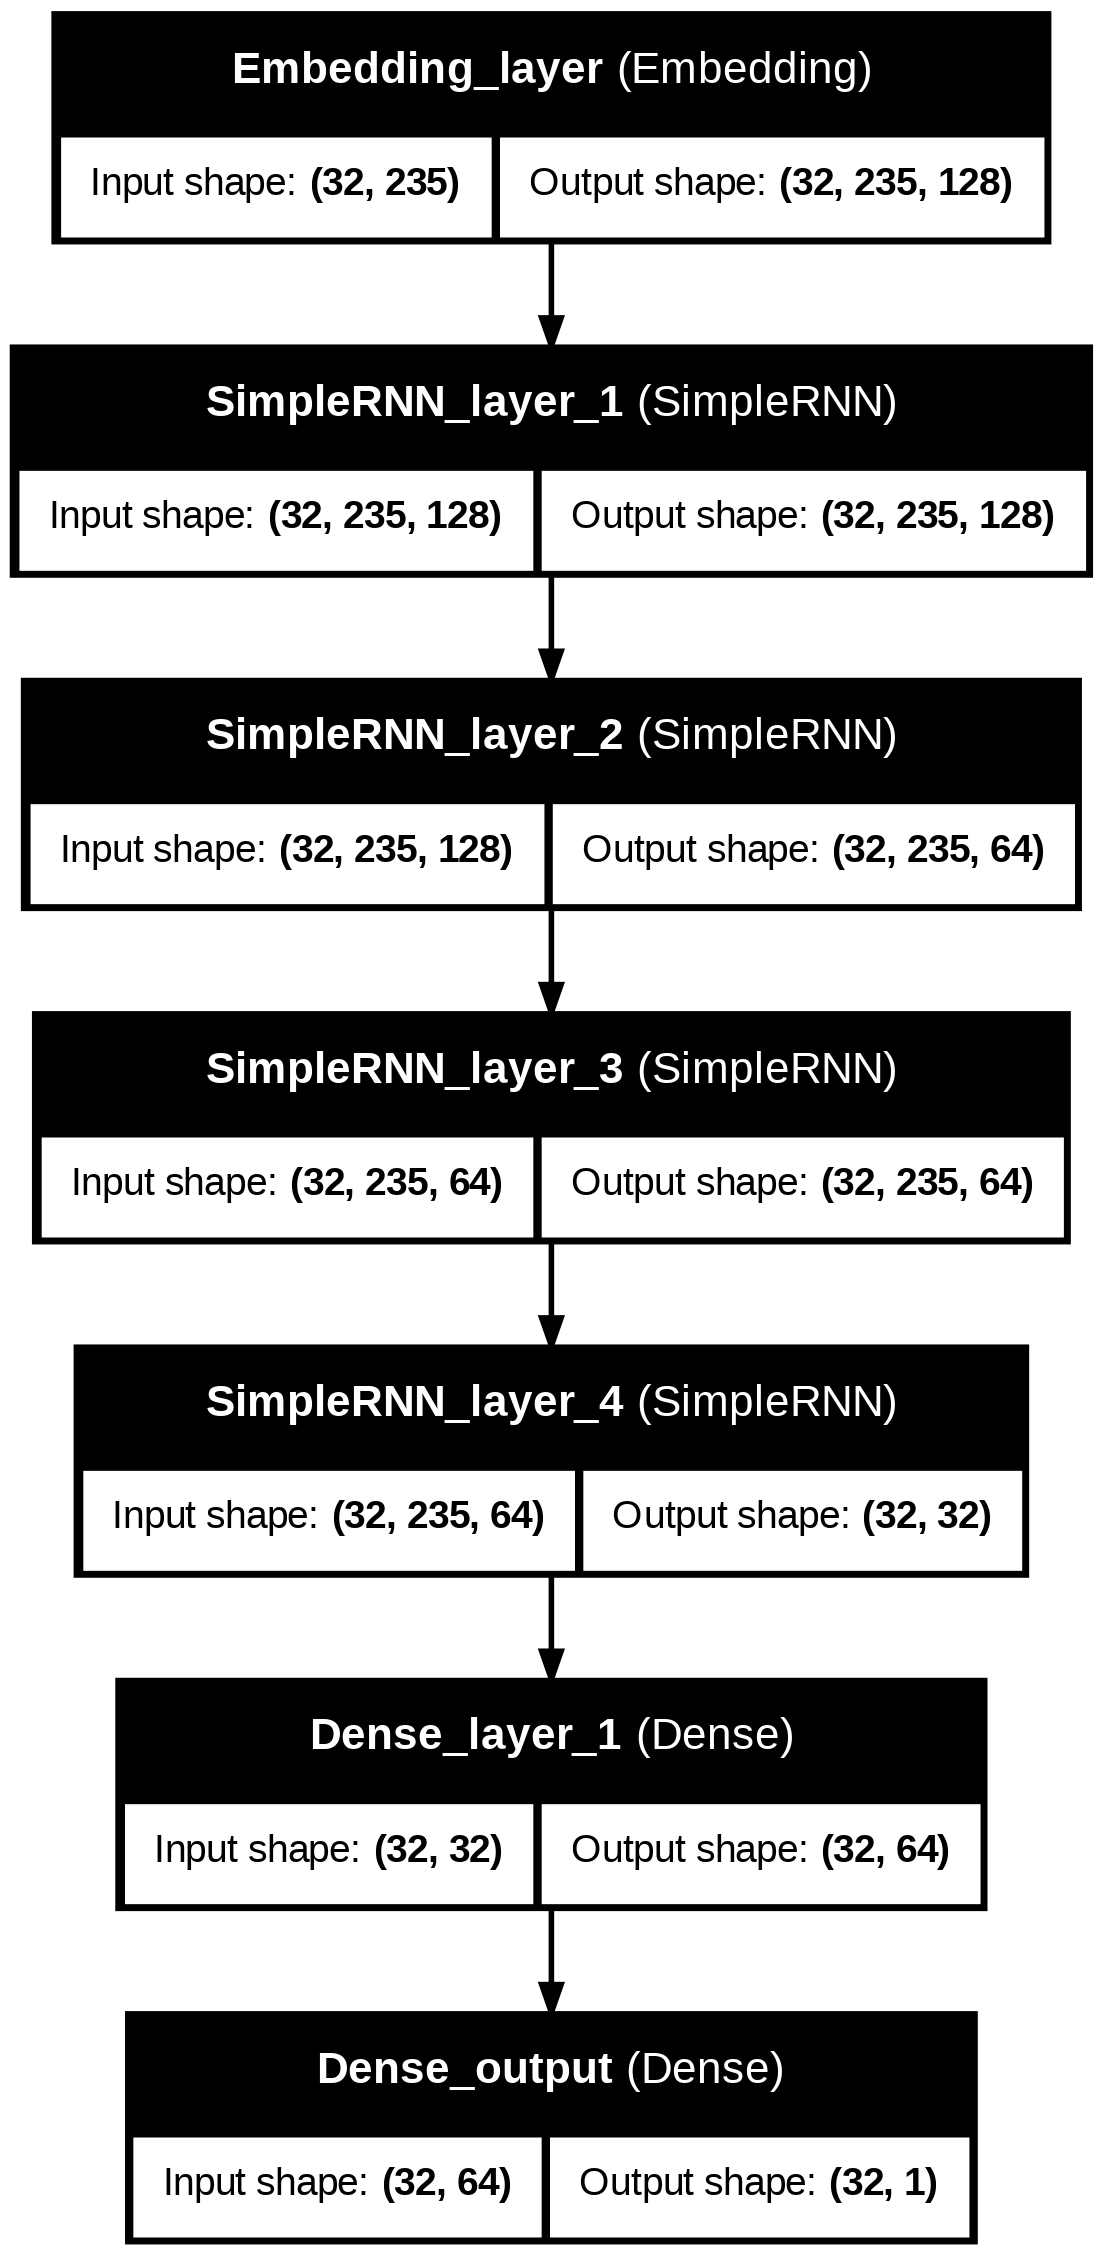

In [ ]:
plot_model(RNN_simple, show_shapes=True, show_layer_names= True)

### **plot loss and accuracy curves.**

In [21]:
def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

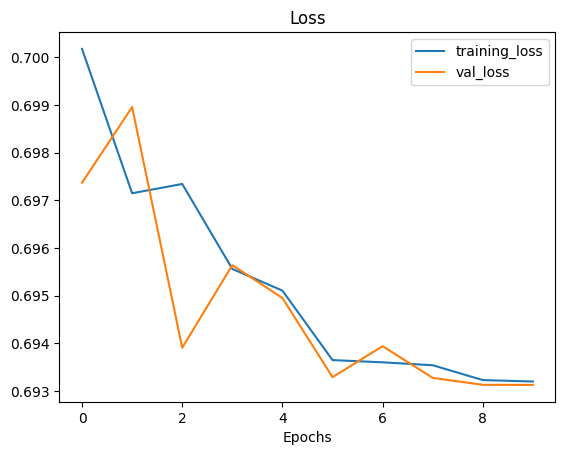

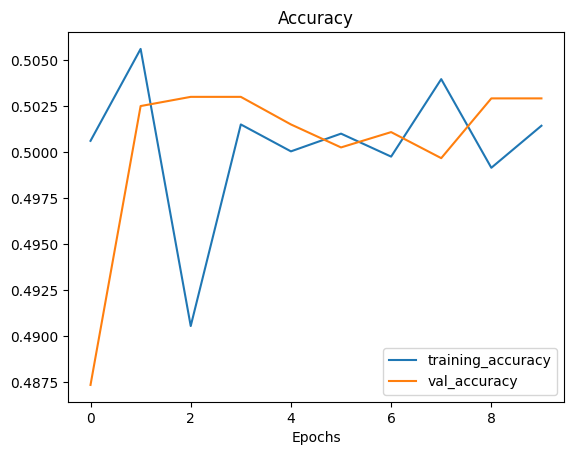

In [22]:
plot_loss_curves(RNN_simple_history)

### **Perform prediction and evaluation of our model.**

In [23]:
Prediction = RNN_simple.predict(X_test)
Loss, Accuracy = RNN_simple.evaluate(X_test, y_test)

375/375 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.5069 - loss: 0.6931


In [24]:
print(f"Model loss on test set: {(Loss):.2f}%")
print(f"Model accuracy on test set: {(Accuracy*100):.0f}%")

Model loss on test set: 0.69%
Model accuracy on test set: 50%


### **Compare predicted values ​to actual values.**

In [25]:
predicted_classes = tf.squeeze(tf.round(Prediction))
predicted_classes

<tf.Tensor: shape=(12000,), dtype=float32, numpy=array([1., 0., 1., ..., 1., 1., 1.], dtype=float32)>

In [26]:
result = predicted_classes == y_test
num_true = 0
num_false = 0
for i in result:
  if i == True:
    num_true += 1
  else:
    num_false += 1

In [27]:
print(f"Number of total label {len(y_test)}")
print(f"Number of true predictions: {num_true}")
print(f"Number of false predictions: {num_false}")

Number of total label 12000
Number of true predictions: 6035
Number of false predictions: 5965


# **Build LSTM RNN model.**

In [28]:
RNN_LSTM = tf.keras.Sequential()
RNN_LSTM.add(tf.keras.layers.Embedding(input_dim=14000, output_dim=128, input_length=235,
                                         name='Embedding_layer'))
RNN_LSTM.add(tf.keras.layers.LSTM(128 ,activation = 'tanh' ,return_sequences=True, name='LSTM_layer_1'))
RNN_LSTM.add(tf.keras.layers.LSTM(128 ,activation = 'tanh' ,return_sequences=True ,name='LSTM_layer_2'))
RNN_LSTM.add(tf.keras.layers.Dropout(0.2, name='Dropout_layer_1'))
RNN_LSTM.add(tf.keras.layers.LSTM(128 ,activation = 'tanh' ,return_sequences=True ,name='LSTM_layer_3'))
RNN_LSTM.add(tf.keras.layers.LSTM(128 ,activation = 'tanh' ,name='LSTM_layer_4'))
RNN_LSTM.add(tf.keras.layers.Dropout(0.2, name='Dropout_layer_2'))
RNN_LSTM.add(tf.keras.layers.Dense(64, activation='relu', name='Dense_layer_1'))
RNN_LSTM.add(tf.keras.layers.Dense(1, activation='sigmoid', name='Dense_output'))

### **Compiling a RNN_LSTM model.**

In [29]:
RNN_LSTM.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

### **RNN_LSTM model training.**

In [30]:
RNN_LSTM_history = RNN_LSTM.fit(X_train,
                                y_train,
                                batch_size=32,
                                epochs=Epochs+5,
                                validation_data= (X_test, y_test),
                                validation_steps=int(0.2 * len(x_test)),
                                callbacks=[Model_CheckPoint, Early_Stopping, Reduce_Learningrate])

Epoch 1/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 0.7305 - loss: 0.5334 - val_accuracy: 0.8083 - val_loss: 0.4443 - learning_rate: 0.0010
Epoch 2/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 31s 36ms/step - accuracy: 0.8772 - loss: 0.3059 - val_accuracy: 0.8251 - val_loss: 0.4557 - learning_rate: 0.0010
Epoch 3/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - accuracy: 0.9136 - loss: 0.2263 - val_accuracy: 0.8561 - val_loss: 0.3389 - learning_rate: 0.0010
Epoch 4/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 40s 37ms/step - accuracy: 0.9292 - loss: 0.1887 - val_accuracy: 0.8626 - val_loss: 0.3735 - learning_rate: 0.0010
Epoch 5/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9458 - loss: 0.1523
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
875/875 ━━━━━━━━━━━━━━━━━━━━ 42s 37ms/step - accuracy: 0.9458 - loss: 0.1523 - val_accuracy: 0.8727 - val_loss: 0.3440 - learning_rate: 0.0010
Epoch 6/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9703 - lo

### **RNN_LSTM model summary.**

In [31]:
RNN_LSTM.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Embedding_layer (Embedding)          │ (32, 200, 128)              │       1,792,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM_layer_1 (LSTM)                  │ (32, 200, 128)              │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM_layer_2 (LSTM)                  │ (32, 200, 128)              │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_layer_1 (Dropout)            │ (32, 200, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM_layer_3 (LSTM)                  │ (32, 200, 128)              │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM_layer_4 (LSTM)                  │ (32, 128)                   │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_layer_2 (Dropout)            │ (32, 128)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_layer_1 (Dense)                │ (32, 64)                    │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_output (Dense)                 │ (32, 1)                     │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,979,973 (26.63 MB)

 Trainable params: 2,326,657 (8.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,653,316 (17.75 MB)

### **Plot model.**

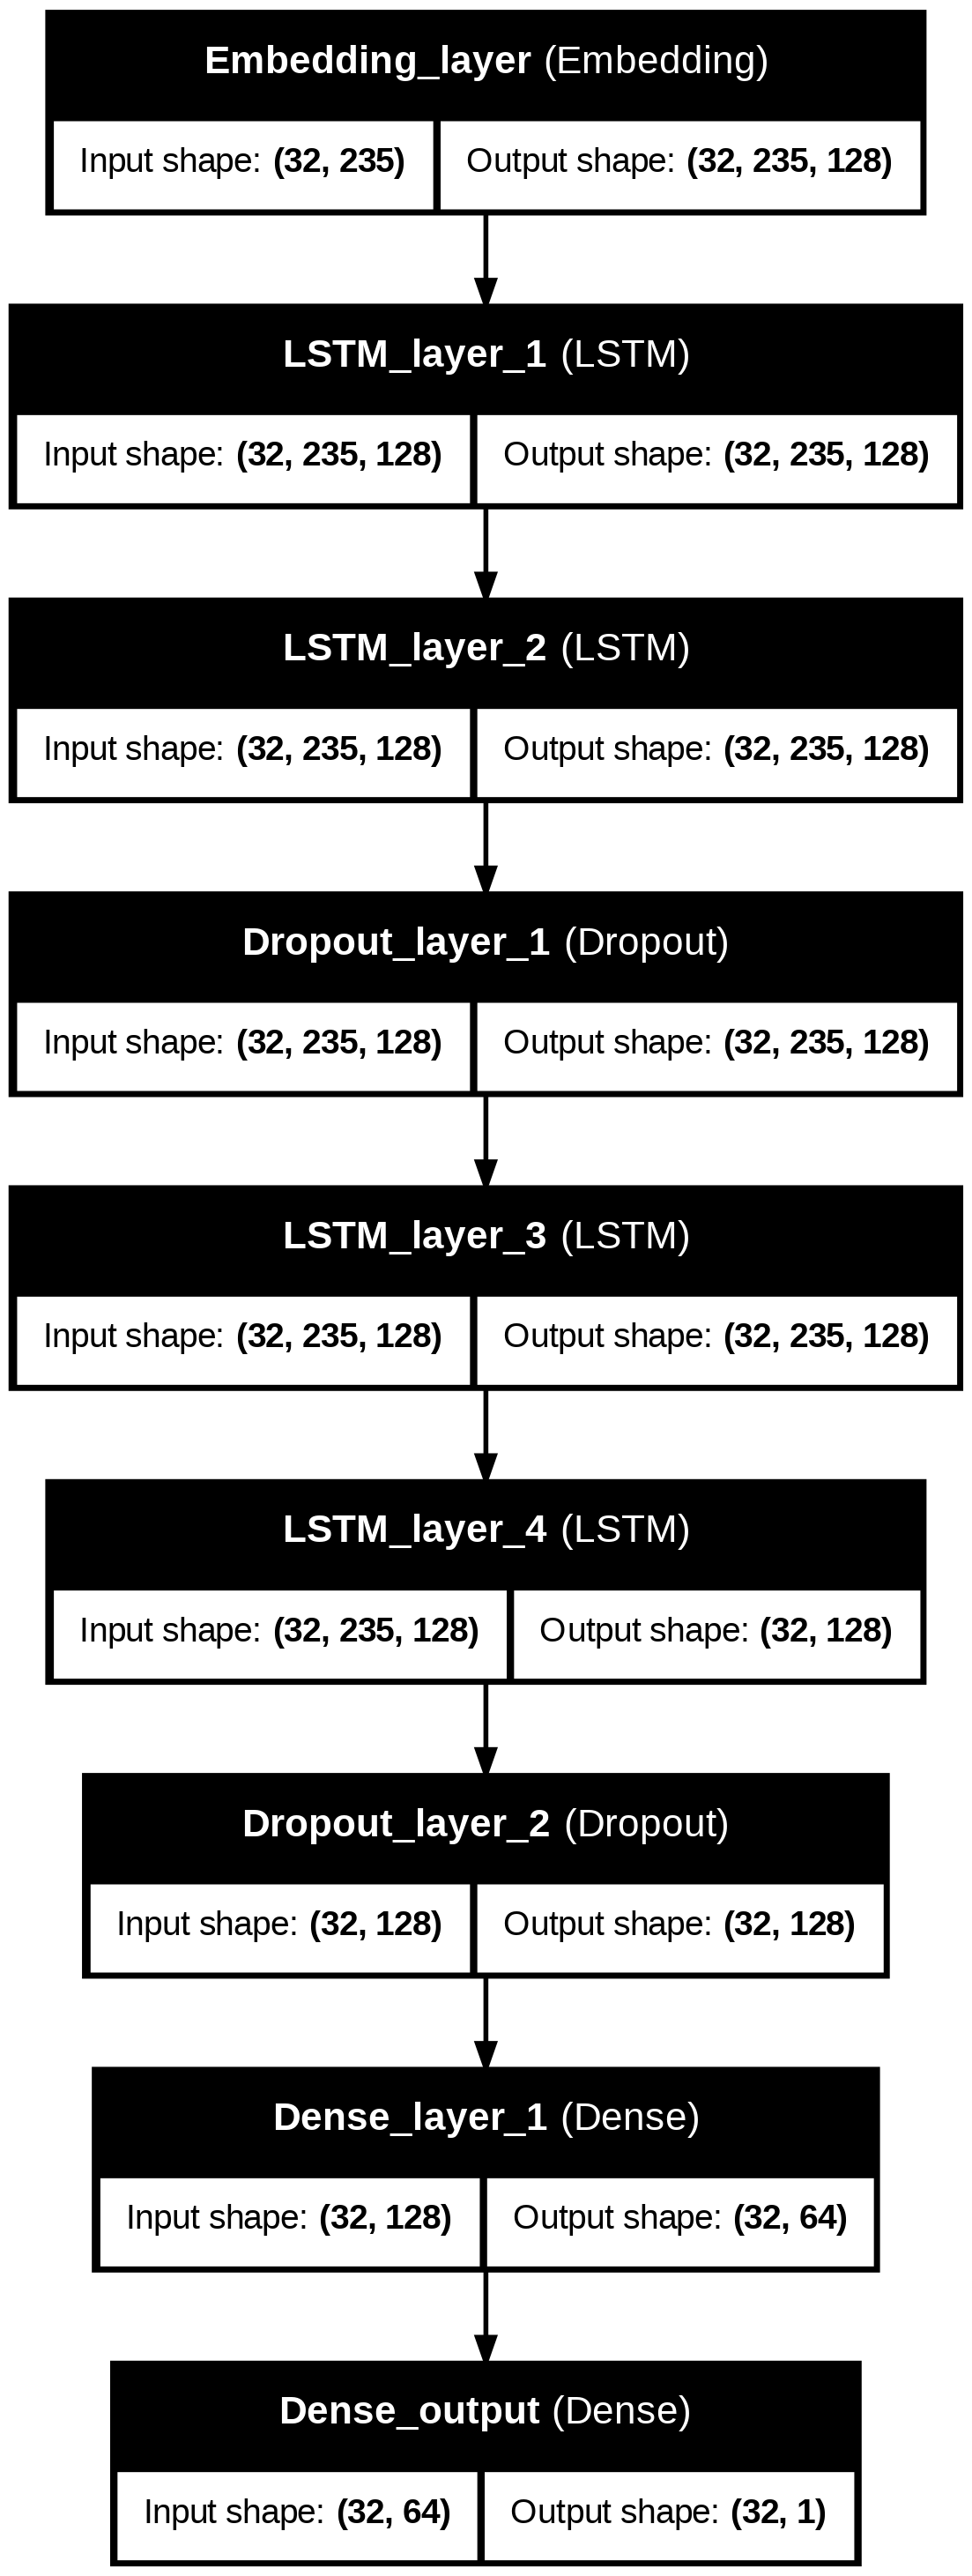

In [ ]:
plot_model(RNN_LSTM, show_shapes=True, show_layer_names= True)

### **plot loss and accuracy curves.**

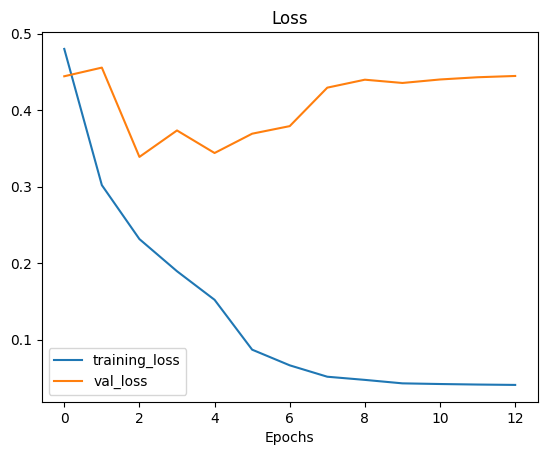

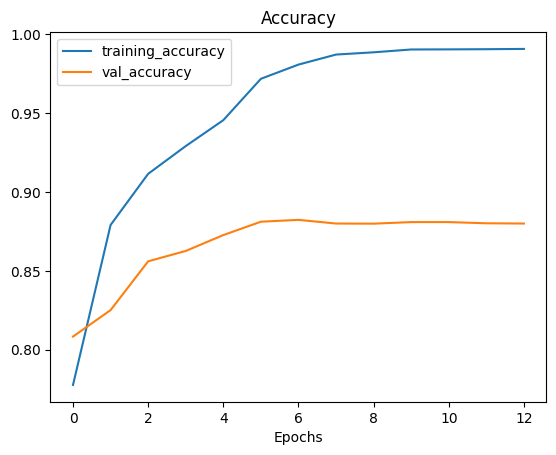

In [32]:
plot_loss_curves(RNN_LSTM_history)

### **Perform prediction and evaluation of our model.**

In [33]:
Prediction_LSTM = RNN_LSTM.predict(X_test)
Loss_LSTM, Accuracy_LSTM = RNN_LSTM.evaluate(X_test, y_test)

375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8604 - loss: 0.3424


In [34]:
print(f"Model loss on test set: {(Loss_LSTM):.2f}%")
print(f"Model accuracy on test set: {(Accuracy_LSTM*100):.0f}%")

Model loss on test set: 0.34%
Model accuracy on test set: 86%


### **Compare predicted values ​to actual values.**

In [35]:
Prediction_classes_LSTM = tf.squeeze(tf.round(Prediction_LSTM))
Prediction_classes_LSTM

<tf.Tensor: shape=(12000,), dtype=float32, numpy=array([0., 1., 0., ..., 1., 0., 0.], dtype=float32)>

In [36]:
result_LSTM = Prediction_classes_LSTM == y_test
num_true_LSTM = 0
num_false_LSTM = 0
for i in result_LSTM:
  if i == True:
    num_true_LSTM += 1
  else:
    num_false_LSTM += 1

In [37]:
print(f"Number of total label {len(y_test)}")
print(f"Number of true predictions: {num_true_LSTM}")
print(f"Number of false predictions: {num_false_LSTM}")

Number of total label 12000
Number of true predictions: 10300
Number of false predictions: 1700


# **Build GUR RNN model.**

In [38]:
RNN_GRU = tf.keras.Sequential()
RNN_GRU.add(tf.keras.layers.Embedding(input_dim=14000, output_dim=128, input_length=235,
                                         name='Embedding_layer'))
RNN_GRU.add(tf.keras.layers.GRU(128 ,activation = 'tanh' ,return_sequences=True, name='GRU_layer_1'))
RNN_GRU.add(tf.keras.layers.GRU(128 ,activation = 'tanh' ,return_sequences=True ,name='GRU_layer_2'))
RNN_GRU.add(tf.keras.layers.Dropout(0.2, name='Dropout_layer_1'))
RNN_GRU.add(tf.keras.layers.GRU(128 ,activation = 'tanh' ,return_sequences=True ,name='GRU_layer_3'))
RNN_GRU.add(tf.keras.layers.GRU(128 ,activation = 'tanh' ,name='GRU_layer_4'))
RNN_GRU.add(tf.keras.layers.Dropout(0.2, name='Dropout_layer_2'))
RNN_GRU.add(tf.keras.layers.Dense(64, activation='relu', name='Dense_layer_1'))
RNN_GRU.add(tf.keras.layers.Dense(1, activation='sigmoid', name='Dense_output'))

### **Compiling a RNN_GRU model.**

In [39]:
RNN_GRU.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

### **RNN_GRU model training.**

In [40]:
RNN_GRU_history = RNN_GRU.fit(X_train,
                              y_train,
                              batch_size=32,
                              epochs=Epochs+5,
                              validation_data= (X_test, y_test),
                              validation_steps=int(0.2 * len(x_test)),
                              callbacks=[Model_CheckPoint, Early_Stopping, Reduce_Learningrate])

Epoch 1/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 35s 36ms/step - accuracy: 0.7279 - loss: 0.5092 - val_accuracy: 0.8195 - val_loss: 0.3699 - learning_rate: 0.0010
Epoch 2/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 31s 36ms/step - accuracy: 0.9268 - loss: 0.1994 - val_accuracy: 0.8859 - val_loss: 0.2642 - learning_rate: 0.0010
Epoch 3/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.9607 - loss: 0.1180 - val_accuracy: 0.8852 - val_loss: 0.3050 - learning_rate: 0.0010
Epoch 4/15
874/875 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9831 - loss: 0.0555
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
875/875 ━━━━━━━━━━━━━━━━━━━━ 42s 37ms/step - accuracy: 0.9830 - loss: 0.0555 - val_accuracy: 0.8780 - val_loss: 0.4174 - learning_rate: 0.0010
Epoch 5/15
875/875 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9945 - loss: 0.0235 - val_accuracy: 0.8815 - val_loss: 0.5070 - learning_rate: 2.0000e-04
Epoch 6/15
874/875 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9983 -

### **RNN_GRU model summary.**

In [41]:
RNN_GRU.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Embedding_layer (Embedding)          │ (32, 200, 128)              │       1,792,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_layer_1 (GRU)                    │ (32, 200, 128)              │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_layer_2 (GRU)                    │ (32, 200, 128)              │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_layer_1 (Dropout)            │ (32, 200, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_layer_3 (GRU)                    │ (32, 200, 128)              │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_layer_4 (GRU)                    │ (32, 128)                   │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_layer_2 (Dropout)            │ (32, 128)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_layer_1 (Dense)                │ (32, 64)                    │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_output (Dense)                 │ (32, 1)                     │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,589,829 (25.14 MB)

 Trainable params: 2,196,609 (8.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,393,220 (16.76 MB)

### **Plot model.**

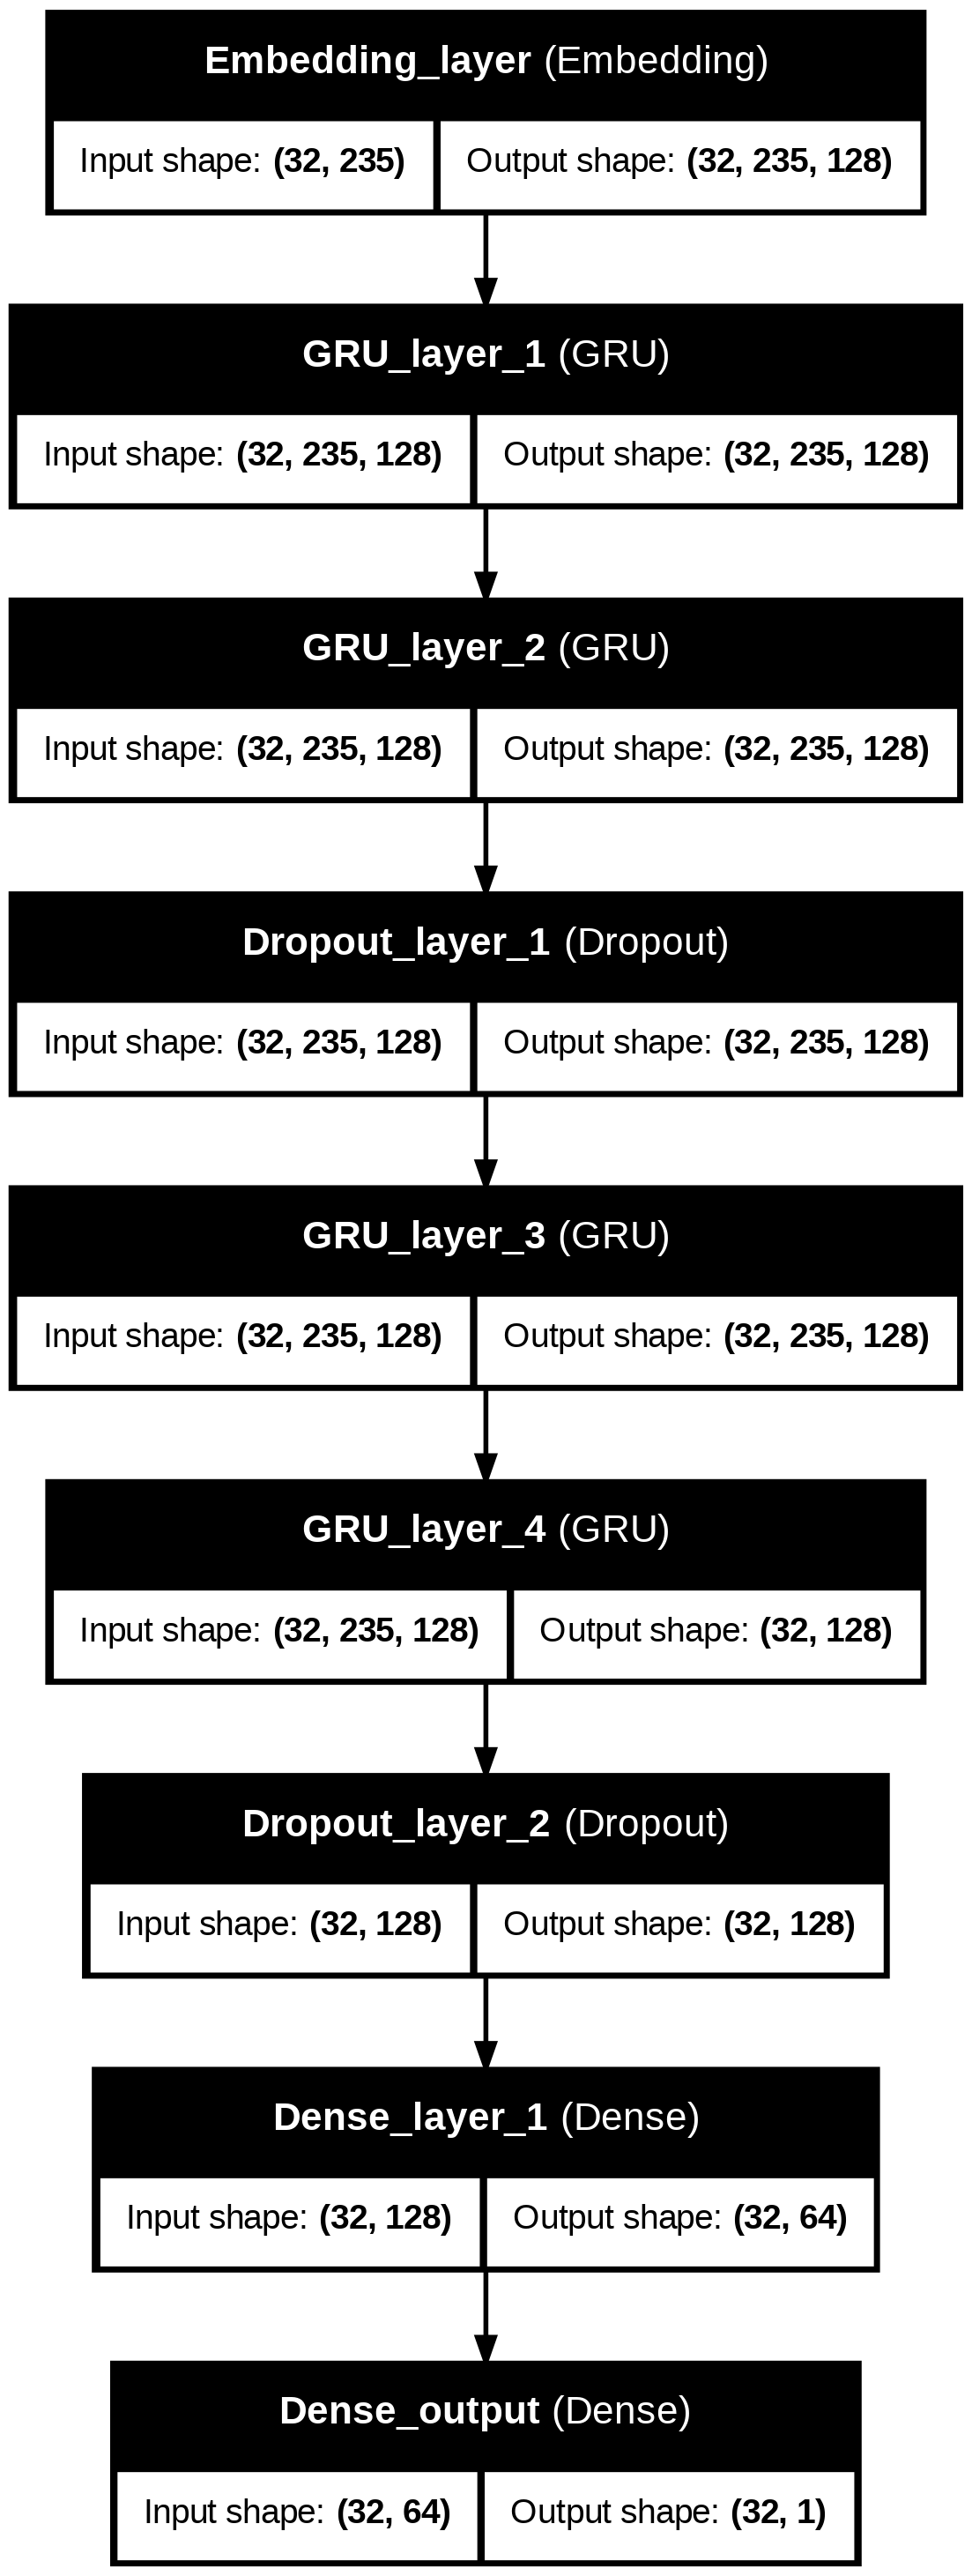

In [ ]:
plot_model(RNN_GRU, show_shapes=True, show_layer_names= True)

### **plot loss and accuracy curves.**

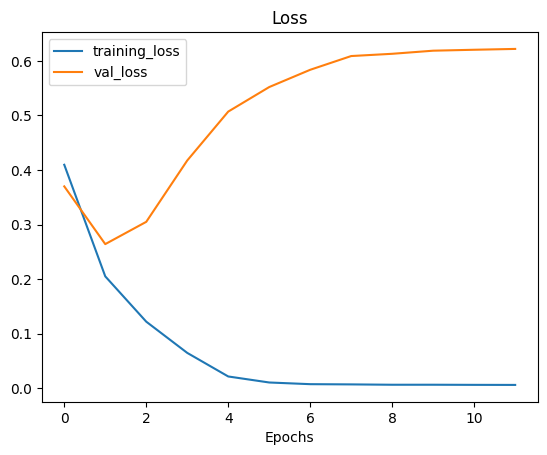

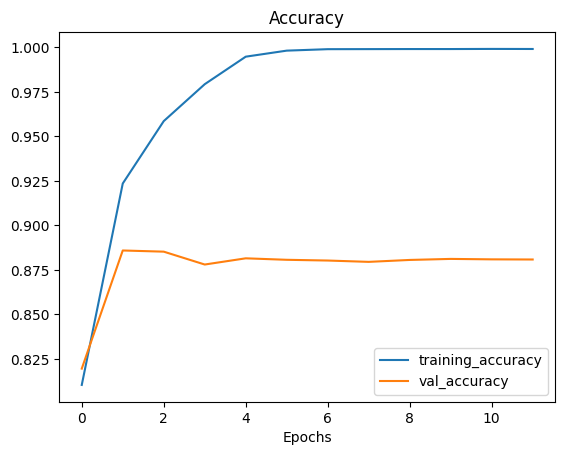

In [42]:
plot_loss_curves(RNN_GRU_history)

### **perform prediction and evaluation of our model.**

In [43]:
Prediction_GRU = RNN_GRU.predict(X_test)
Loss_GRU, Accuracy_GRU = RNN_GRU.evaluate(X_test, y_test)

375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8871 - loss: 0.2723


In [44]:
print(f"Model loss on test set: {(Loss_GRU):.2f}%")
print(f"Model accuracy on test set: {(Accuracy_GRU*100):.0f}%")

Model loss on test set: 0.26%
Model accuracy on test set: 89%


### **Compare predicted values ​to actual values.**

In [45]:
Prediction_classes_GRU = tf.squeeze(tf.round(Prediction_GRU))
Prediction_classes_GRU

<tf.Tensor: shape=(12000,), dtype=float32, numpy=array([0., 1., 1., ..., 1., 0., 0.], dtype=float32)>

In [46]:
result_GRU = Prediction_classes_GRU == y_test
num_true_GRU = 0
num_false_GRU = 0
for i in result_GRU:
  if i == True:
    num_true_GRU += 1
  else:
    num_false_GRU += 1

In [47]:
print(f"Number of total label {len(y_test)}")
print(f"Number of true predictions: {num_true_GRU}")
print(f"Number of false predictions: {num_false_GRU}")

Number of total label 12000
Number of true predictions: 10659
Number of false predictions: 1341


# **You can use a bidirectional layer for the RNN model.**



```
RNN_GRU = tf.keras.Sequential()
RNN_GRU.add(tf.keras.layers.Embedding(input_dim=14000, output_dim=128, input_length=235, name='Embedding_layer'))
RNN_GRU.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, activation='tanh', return_sequences=True), name='Bidirectional_GRU_layer_1'))
RNN_GRU.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, activation='tanh', return_sequences=True), name='Bidirectional_GRU_layer_2'))
RNN_GRU.add(tf.keras.layers.Dropout(0.2, name='Dropout_layer_1'))
RNN_GRU.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, activation='tanh', return_sequences=True), name='Bidirectional_GRU_layer_3'))
RNN_GRU.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, activation='tanh'), name='Bidirectional_GRU_layer_4'))
RNN_GRU.add(tf.keras.layers.Dropout(0.2, name='Dropout_layer_2'))
RNN_GRU.add(tf.keras.layers.Dense(64, activation='relu', name='Dense_layer_1'))
RNN_GRU.add(tf.keras.layers.Dense(1, activation='sigmoid', name='Dense_output'))
```
### **Within the bidirectional layers you can use each one.**



*   tf.keras.layers.SimpleRNN
*   tf.keras.layers.LSTM
*   tf.keras.layers.GRU






# **To improve the performance of your model, you can do this.**



*   Adding layers.
*   Increase the number of neurons in hidden layers.
*   Change the activation function.
*   Change the optimization function.
*   Change the Learning rate.
*   Fitting on more data.
*   Fitting for longer.

### **You can do all this using fine-tuning code.**

# **Fine tuning.**

### **Run the cell to made a fine tuning to your model then. Rebuild the model after fine-tuning the number of layers, the number of neurons in each layer, and the dropout rate, compile the model and train the model.**

In [ ]:
''''
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from kerastuner import Hyperband

# Define the model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()

    # Embedding Layer: Tune input dimension (vocab size) and output dimension (embedding size)
    model.add(Embedding(input_dim=hp.Int('embedding_input_dim', min_value=1000, max_value=20000, step=1000),
                        output_dim=hp.Int('embedding_output_dim', min_value=32, max_value=256, step=32),
                        input_length=235,
                        name='Embedding_layer'))

    # RNN Layers: Tune the number of layers and units in each LSTM layer
    num_rnn_layers = hp.Int('num_RNN_layers', min_value=3, max_value=9, step=1)
    for i in range(num_rnn_layers):
        model.add(LSTM(units=hp.Int(f'lstm_units_{i}', min_value=32, max_value=128, step=32),
                       activation=hp.Choice(f'rnn_activation_function_{i}', values=['relu', 'tanh', 'sigmoid']),
                       return_sequences=True if i < num_rnn_layers - 1 else False))

    # Dense Layers: Tune the number of layers, units, activation, and dropout rate
    num_dense_layers = hp.Int('num_dense_layers', min_value=1, max_value=5, step=1)
    for i in range(num_dense_layers):
        model.add(Dense(units=hp.Int(f'dense_units_{i}', min_value=64, max_value=256, step=64),
                        activation=hp.Choice(f'dense_activation_function_{i}', values=['relu', 'tanh', 'sigmoid'])))
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))

    # Output Layer: Sigmoid activation for binary classification
    model.add(Dense(units=1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5,
                                                                            max_value=1e-1, sampling='LOG')),
                  loss='binary_crossentropy',  # Binary classification loss
                  metrics=['accuracy'])

    return model

# Instantiate the tuner with Hyperband algorithm
tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=5,  # Aggressive elimination, tune this based on your requirements
    directory='my_dir',
    project_name='rnn_embedding_tuning',
    max_consecutive_failed_trials=5  # Allows up to 5 failed trials before stopping
)

# Assuming your training and test data are available in variables X_train, y_train, X_test, y_test
# Make sure data is correctly shaped and valid for the model
try:
    # Train the model using the tuner
    tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=15)
except Exception as e:
    print(f"Error during tuning: {e}")

# Retrieve the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters for the Embedding layer
print(f"Best Embedding Input Dim (Vocab Size): {best_hyperparameters.get('embedding_input_dim')}")
print(f"Best Embedding Output Dim (Embedding Size): {best_hyperparameters.get('embedding_output_dim')}")

# Print the best hyperparameters for the RNN and Dense layers
print(f"Best Number of RNN Layers: {best_hyperparameters.get('num_RNN_layers')}")
for i in range(best_hyperparameters.get('num_RNN_layers')):
    print(f"Best Number of Units in RNN Layer {i + 1}: {best_hyperparameters.get(f'lstm_units_{i}')}")

print(f"Best Number of Dense Layers: {best_hyperparameters.get('num_dense_layers')}")
for i in range(best_hyperparameters.get('num_dense_layers')):
    print(f"Best Number of Neurons in Dense Layer {i + 1}: {best_hyperparameters.get(f'dense_units_{i}')}")
    print(f"Best Activation Function in Dense Layer {i + 1}: {best_hyperparameters.get(f'dense_activation_function_{i}')}")
    print(f"Best Dropout Rate after Dense Layer {i + 1}: {best_hyperparameters.get(f'dropout_{i}')}")

# Print the best learning rate
print(f"Best Learning Rate: {best_hyperparameters.get('learning_rate')}")

'''''

### **Run this cell to remove the fine tuning.**

In [ ]:
#shutil.rmtree('/content/my_dir/rnn_embedding_tuning', ignore_errors=True)

# **Create a dataset contain all result of prediction and compare to actual.**

In [48]:
Result_dataset = pd.DataFrame({'Actual': y_test,
                               'Prediction_simple': predicted_classes,
                               'Prediction_LSTM': Prediction_classes_LSTM,
                               'Prediction_GRU': Prediction_classes_GRU,
                               'Actual to Predicted_simple': predicted_classes == y_test,
                               'Actual to Predicted_LSTM': Prediction_classes_LSTM == y_test,
                               'Actual to Predicted_GRU': Prediction_classes_GRU == y_test})

### **Plot all final result.**

In [49]:
Result_Predicted_simple = Result_dataset['Actual to Predicted_simple'].value_counts()
Result_Predicted_LSTM = Result_dataset['Actual to Predicted_LSTM'].value_counts()
Result_Predicted_GRU = Result_dataset['Actual to Predicted_GRU'].value_counts()

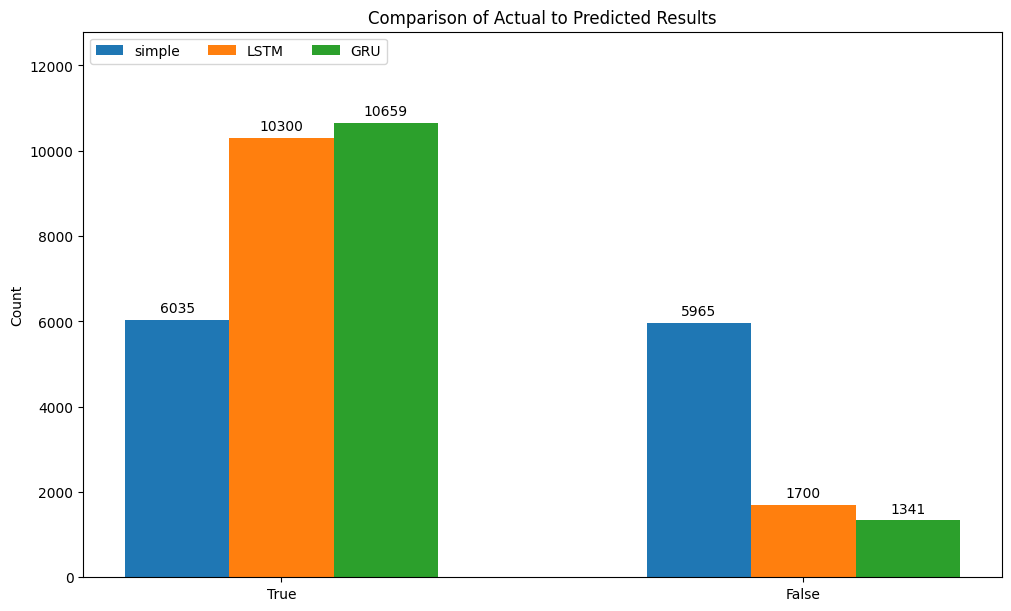

In [50]:
categories = Result_Predicted_simple.index
values = {
    'simple': Result_Predicted_simple.values,
    'LSTM': Result_Predicted_LSTM.values,
    'GRU': Result_Predicted_GRU.values
}

x = np.arange(len(categories))
width = 0.2
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(10, 6))

for attribute, measurement in values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Count')
ax.set_title('Comparison of Actual to Predicted Results')
ax.set_xticks(x + width, categories)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, max([max(val) for val in values.values()]) * 1.2)

plt.show()

# **Save and load models.**

In [51]:
Best_model = RNN_GRU.save('Best_model.h5')

In [52]:
Best_model = tf.keras.models.load_model('Best_model.h5')

In [53]:
Best_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Embedding_layer (Embedding)          │ (32, 200, 128)              │       1,792,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_layer_1 (GRU)                    │ (32, 200, 128)              │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_layer_2 (GRU)                    │ (32, 200, 128)              │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_layer_1 (Dropout)            │ (32, 200, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_layer_3 (GRU)                    │ (32, 200, 128)              │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_layer_4 (GRU)                    │ (32, 128)                   │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_layer_2 (Dropout)            │ (32, 128)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_layer_1 (Dense)                │ (32, 64)                    │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_output (Dense)                 │ (32, 1)                     │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,196,611 (8.38 MB)

 Trainable params: 2,196,609 (8.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [54]:
Best_model.evaluate(X_test, y_test)

375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8871 - loss: 0.2723


[0.2648831009864807, 0.8882499933242798]